## Preprocessing on images

In this file, we are going to perform preprocessing on images.

The preprocessing steps include:

1. **Resizing**: Adjusting the size of the images to a standard dimension.
2. **Cropping**: Removing unwanted areas from the images.
3. **Filtering**: Applying various filters to enhance or suppress certain features in the images.
4. **Noise Removal**: Eliminating noise from the images to improve their quality.
5. **Normalization**: Scaling pixel values to a standard range, typically 0-1.

These steps will prepare our images to be used as ground truth images, which serve as a reference or basis for comparison in various image processing tasks.




In [7]:
from skimage import morphology
import skimage.io as sio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

The following code is used to read the image and convert it to a binary image. The binary image is then used to create a mask for the original image. The mask is then used to extract the region of interest (ROI) from the original image.

In this way we will use this image as our `ground truth`

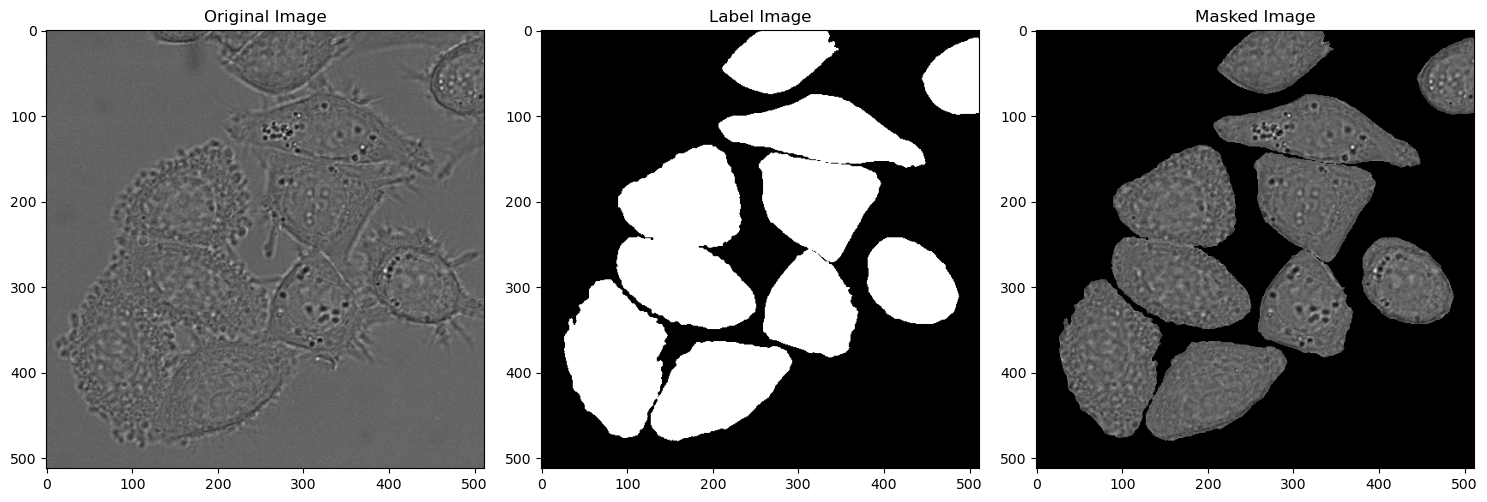

In [8]:
def read_image(image_path:str)->np.ndarray:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return image

def read_label(label_path:str, use_morphology:bool=False)->np.ndarray:
    """
    Read and process label image.

    Parameters:
    label_path (str): The path to the label image file.
    use_morphology (bool, optional): Whether to apply morphology operations on the label image. 
                                     Defaults to False.

    Returns:
    numpy.ndarray: The processed label image.

    """
    label = sio.imread(label_path)
    if use_morphology:
        markers = np.zeros_like(label)
        for i in range(1, label.max() + 1):
            mask = label == i
            dilated_mask = morphology.binary_dilation(mask, np.ones((3, 3)))
            border_mask = dilated_mask & ~mask
            markers[border_mask] = 1
    else:
        label = np.where(label > 0, 1, 0).astype(np.float32)
    
    return markers.astype('float32') if use_morphology else label
    
def overlay_mask(image:np.ndarray, mask:np.ndarray)->np.ndarray:
    """
    Overlay a binary mask on top of an image.

    Parameters:
    image (numpy.ndarray): The input image.
    mask (numpy.ndarray): The binary mask to overlay.

    Returns:
    numpy.ndarray: The resulting image with the mask overlayed.

    """
    color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    color_image[mask != 1] = [0, 0, 0]  
    return color_image



The following Function get a directory and return a tuple containing two lists:
<br>
<br>
  `([image file paths], [label file paths])`


In [9]:
def get_file_lists(basedir)->tuple:
    """
    Get the list of image and label file paths from the specified directory.

    Args:
        basedir (str): The base directory containing the image and label files.

    Returns:
        tuple: A tuple containing two lists - the image file paths and the label file paths.

    """
    imdirs = sorted([os.path.join(basedir, p) for p in os.listdir(basedir)
                     if p.find('_') == -1
                     and os.path.isdir(os.path.join(basedir, p))])
    stdirs = [f'{p}_ST' for p in imdirs]

    labpaths = sorted([os.path.join(gtdir, 'SEG', p)
                      for gtdir in stdirs
                      for p in os.listdir(os.path.join(gtdir, 'SEG'))])

    impaths = sorted([os.path.join(imdir, p)
                      for imdir in imdirs
                      for p in os.listdir(os.path.join(imdir))])

    return impaths, labpaths


Finally creating a folder called `MASK` based on being train or test. 
<br>
- train : `01_MASK`
- test : `02_MASK`

<span style="color:green;">data_dir</span>  is set to `'Data/train'`,
but you can also uncomment the second line and set it to `'Data/test'`
if you want to use the test data instead.

In [10]:
#data_dir = 'Data/train'
data_dir = 'Data/test'

In [11]:
subname = '/01' if data_dir =='Data/train' else'/02'
impaths, labpaths = get_file_lists(data_dir)

In [12]:
output_folder = f'{data_dir}{subname}_MASKS'
os.makedirs(output_folder, exist_ok=True)

for idx, (image_path, label_path) in enumerate(zip(impaths, labpaths)):
    image = read_image(image_path)
    label = read_label(label_path)
    # masked_image = overlay_mask(image, label)
    
    # Save the highlighted image
    output_filename = f'mask_{idx:03d}.tif'
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, label)
    plt.show()

